# MLDA for the Basin using `gpuocean.dataassimilation.MLEnKF`

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Rossby utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 

## Data Assimilation

In [6]:
from utils.BasinSL import *

In [7]:
ls = [6, 7, 8, 9]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
from utils.BasinParameters import * 

In [10]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [11]:
T = 900

### Truth

In [12]:
truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args)
init_mekl.perturbSim(truth)

In [13]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [14]:
obs_x = 40040.0
obs_y = 80040.0

Hx, Hy = SLobsCoord2obsIdx(truth, obs_x, obs_y)

In [15]:
obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

Text(0.5, 0.85, 'Truth')

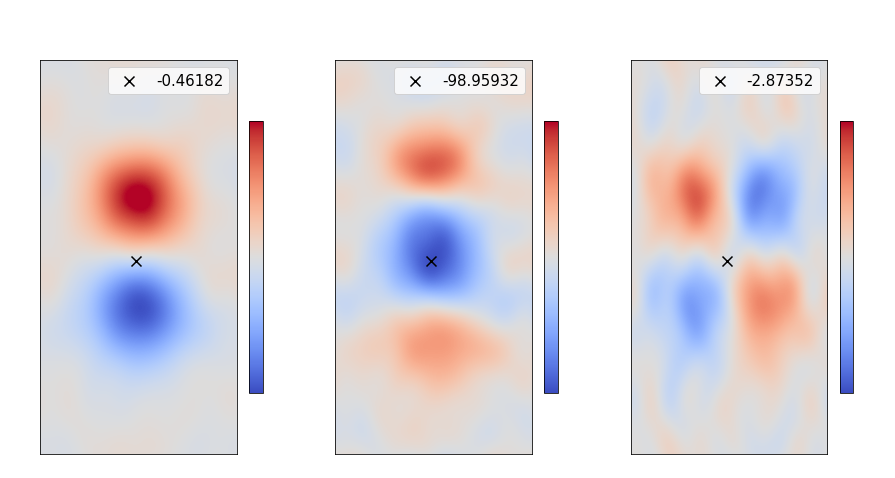

In [16]:
fig, axs = imshow3([true_eta, true_hu, true_hv], eta_vlim=3, huv_vlim=100)
axs[0].scatter(Hx,Hy, marker="x", c="black", label=str(round(obs[0],5)), s=100)
axs[0].legend(labelcolor="black", fontsize=15)
axs[1].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[1],5)), s=100)
axs[1].legend(labelcolor="black", fontsize=15)
axs[2].scatter(Hx, Hy, marker="x", c="black", label=str(round(obs[2],5)), s=100)
axs[2].legend(labelcolor="black", fontsize=15)
fig.suptitle("Truth", y=0.85)


### Ensemble sizes 

In [17]:
Nes = [100, 75, 50, 25]

In [18]:
SL_Ne = 100

### One-level Ensemble

In [19]:
SL_ensemble = initSLensemble(SL_Ne, args_list[-1], data_args_list[-1], sample_args, 
                    init_model_error_basis_args=init_model_error_basis_args, 
                    sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=sim_model_error_timestep)
SLstep(SL_ensemble, T)
SL_state = SLdownload(SL_ensemble)

SL_prior = copy.deepcopy(SL_state)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

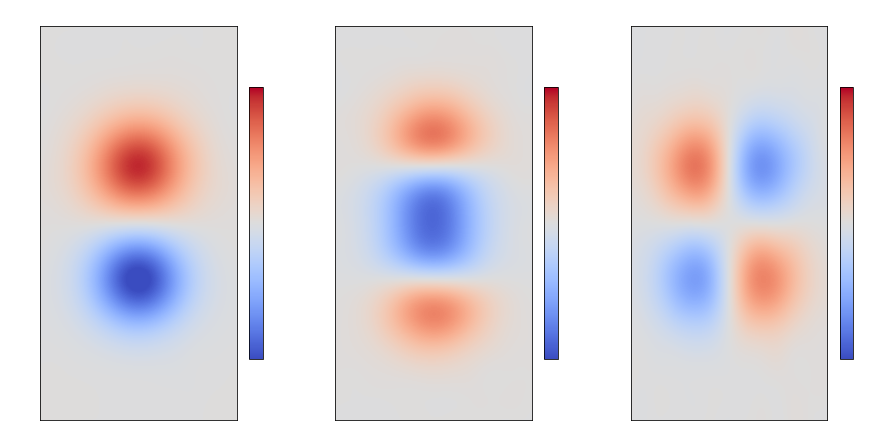

In [20]:
imshow3(np.average(SL_state, axis=-1), eta_vlim=3, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

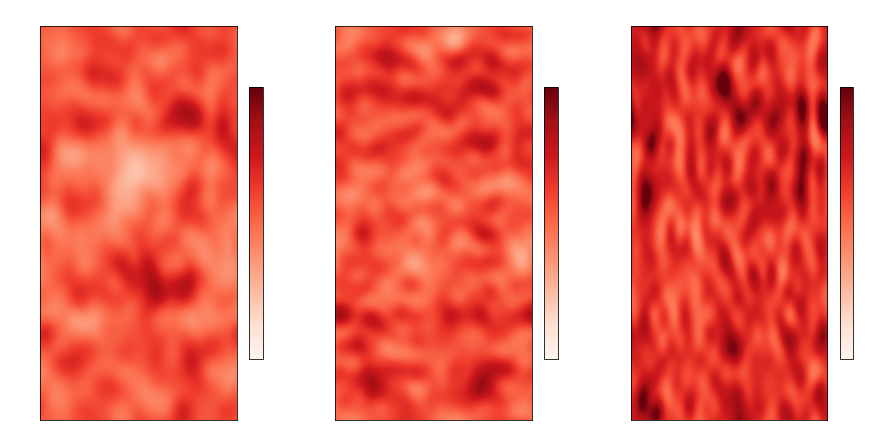

In [21]:
imshow3var(np.var(SL_state, axis=-1), eta_vlim=0.015, huv_vlim=50)

In [22]:
SL_K = SLEnKF(SL_ensemble, obs, obs_x, obs_y, R, obs_var=slice(1,3))
SL_state = SLdownload(SL_ensemble)

Text(0.5, 0.9, 'Kalman Gain')

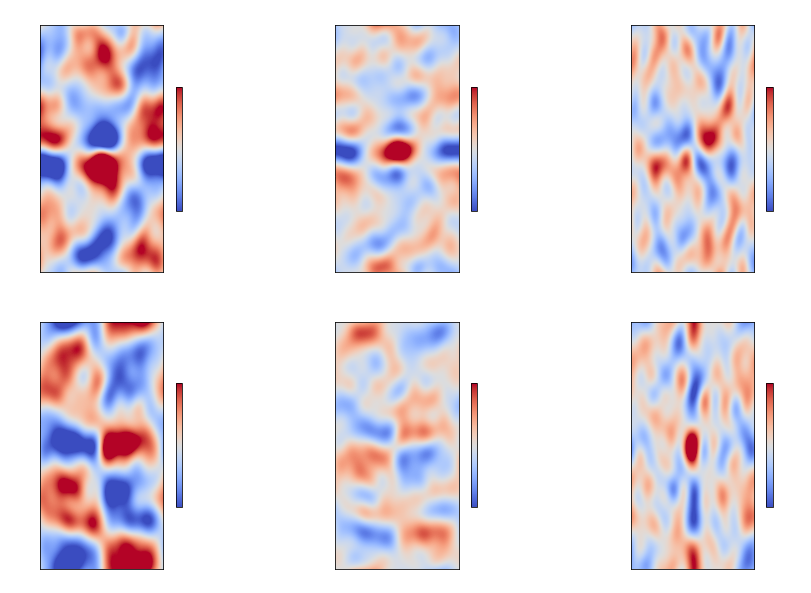

In [23]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

eta_vlim=5e-3
huv_vlim=0.5
cmap="coolwarm"

for i in range(2):
    etahuhv = SL_K[:,:,:,i]

    im = axs[i,0].imshow(etahuhv[0], vmin=-eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,0], shrink=0.5)
    axs[i,0].set_title("$\eta$", fontsize=15)

    im = axs[i,1].imshow(etahuhv[1], vmin=-huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,1], shrink=0.5)
    axs[i,1].set_title("$hu$", fontsize=15)

    im = axs[i,2].imshow(etahuhv[2], vmin=-huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,2], shrink=0.5)
    axs[i,2].set_title("$hv$", fontsize=15)

fig.suptitle("Kalman Gain", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

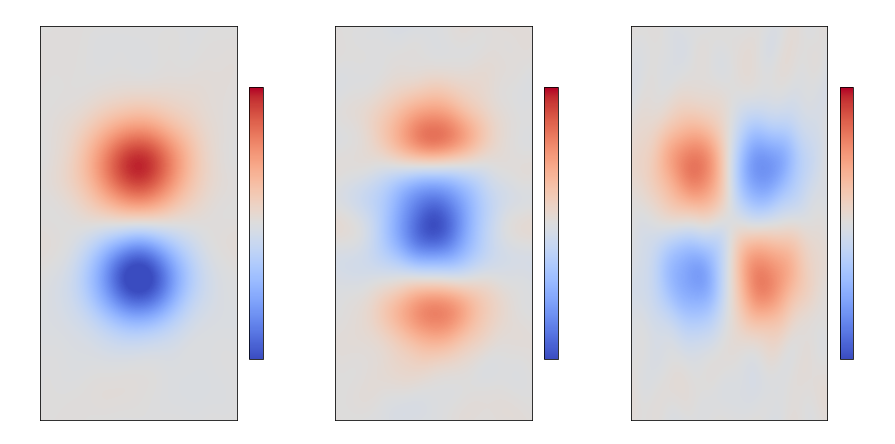

In [24]:
imshow3(np.average(SL_state, axis=-1), eta_vlim=3, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

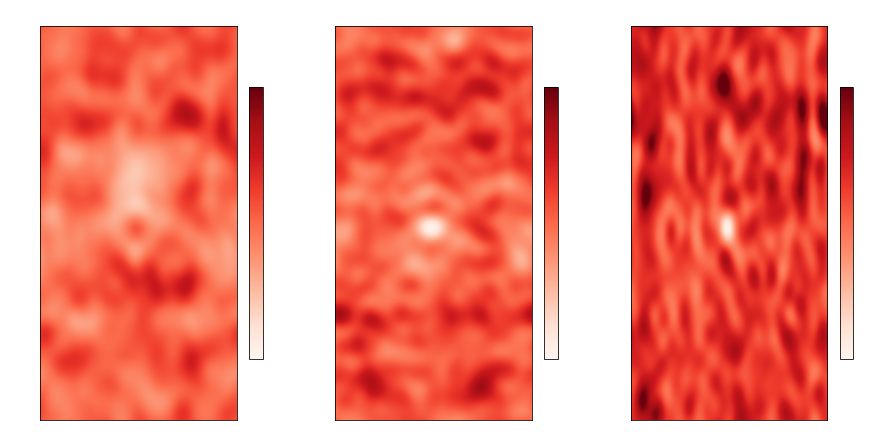

In [25]:
imshow3var(np.var(SL_state, axis=-1), eta_vlim=0.015, huv_vlim=50)

### Multi-level Ensemble

In [27]:
from utils.BasinEnsembleInit import * 

In [28]:
ML_ensemble = initMLensemble(Nes, args_list, data_args_list, sample_args, 
                             init_model_error_basis_args=init_model_error_basis_args, 
                             sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_time_step=60.0)

0
1
2
3


In [29]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [30]:
from importlib import reload
reload(MultiLevelOceanEnsemble)

<module 'gpuocean.ensembles.MultiLevelOceanEnsemble' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/ensembles/MultiLevelOceanEnsemble.py'>

In [31]:
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

In [32]:
MLOceanEnsemble.step(T)

In [33]:
ML_prior_state = copy.deepcopy(MLOceanEnsemble.download())

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

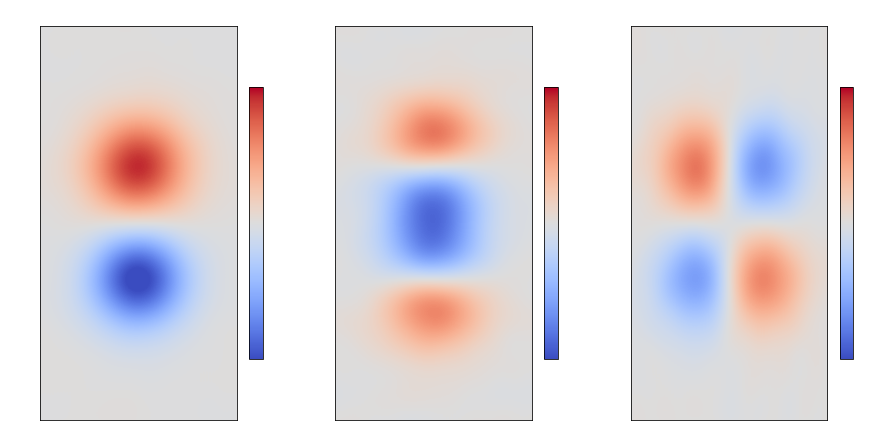

In [34]:
MLmean = MLOceanEnsemble.estimate(np.mean)
imshow3(MLmean, eta_vlim=3, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

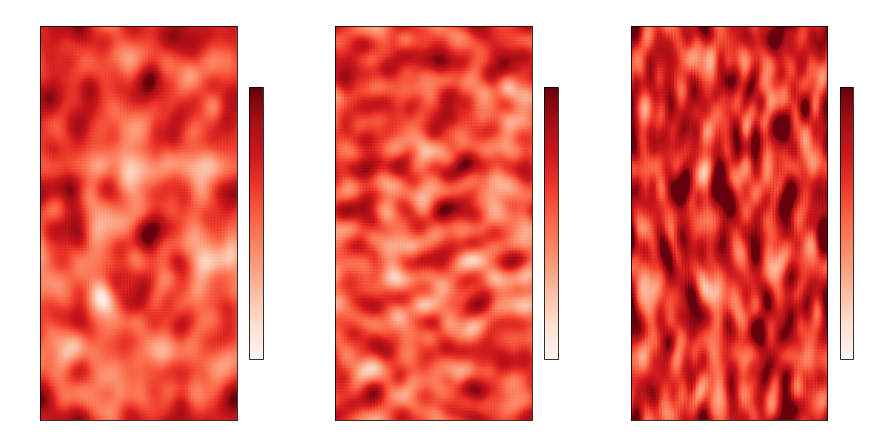

In [35]:
MLvar = MLOceanEnsemble.estimate(np.var)
imshow3var(MLvar, eta_vlim=0.015, huv_vlim=50)

In [36]:
from gpuocean.dataassimilation import MLEnKFOcean
reload(MLEnKFOcean)

<module 'gpuocean.dataassimilation.MLEnKFOcean' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/dataassimilation/MLEnKFOcean.py'>

In [37]:
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)
ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, obs_var=slice(1,3), r = 5*1e7, relax_factor = 1.0)

Text(0.5, 0.9, 'Kalman Gain')

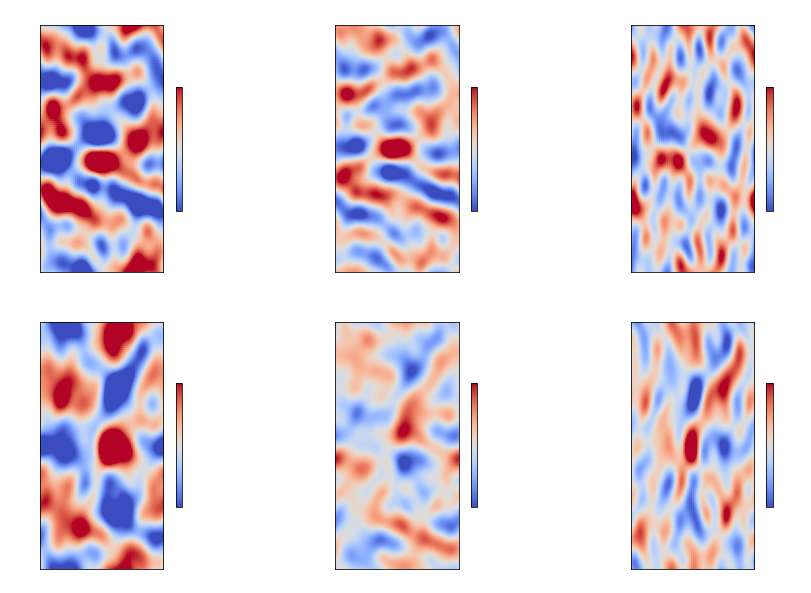

In [39]:
fig, axs = plt.subplots(2,3, figsize=(15,10))

for i in range(2):
    etahuhv = ML_K[:,i].reshape(3, args_list[-1]["ny"], args_list[-1]["nx"])

    im = axs[i,0].imshow(etahuhv[0], vmin=-eta_vlim, vmax=eta_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,0], shrink=0.5)
    axs[i,0].set_title("$\eta$", fontsize=15)

    im = axs[i,1].imshow(etahuhv[1], vmin=-huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,1], shrink=0.5)
    axs[i,1].set_title("$hu$", fontsize=15)

    im = axs[i,2].imshow(etahuhv[2], vmin=-huv_vlim, vmax=huv_vlim, cmap=cmap)
    plt.colorbar(im, ax=axs[i,2], shrink=0.5)
    axs[i,2].set_title("$hv$", fontsize=15)

fig.suptitle("Kalman Gain", y=0.9)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

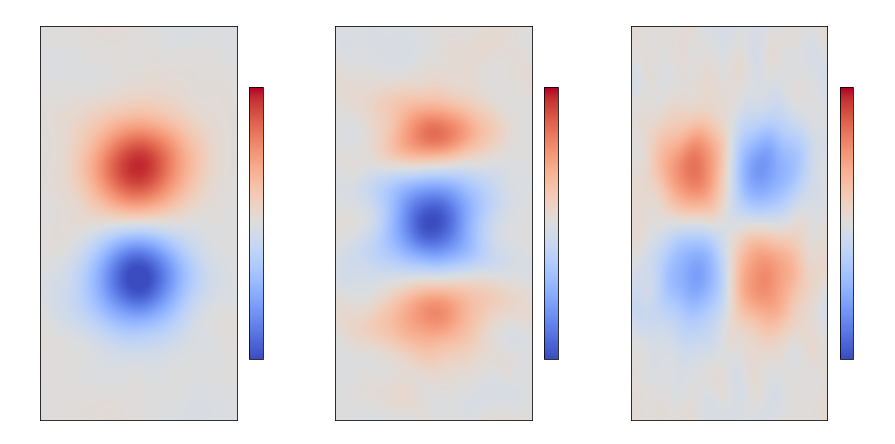

In [40]:
imshow3(MLOceanEnsemble.estimate(np.mean), eta_vlim=3, huv_vlim=100)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:title={'center':'$\\eta$'}>,
        <AxesSubplot:title={'center':'$hu$'}>,
        <AxesSubplot:title={'center':'$hv$'}>], dtype=object))

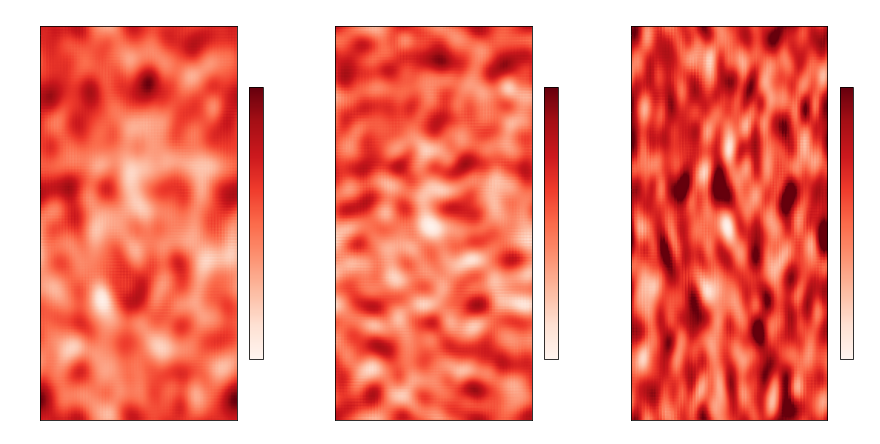

In [41]:
imshow3var(MLOceanEnsemble.estimate(np.var), eta_vlim=0.015, huv_vlim=50)

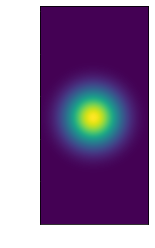

In [42]:
plt.imshow(MLEnKF.GCweights(obs_x, obs_y, r))